In [ ]:
import pandas as pd
file_path = 'CleanOdiBatting.csv'
data = pd.read_csv(file_path)

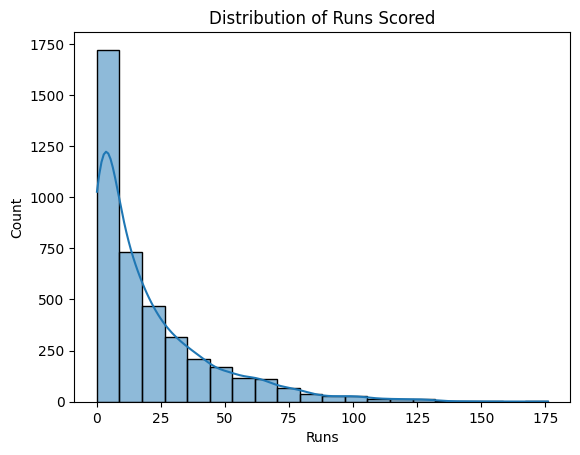

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data['Runs'], bins=20, kde=True)
plt.title("Distribution of Runs Scored")
plt.show()


In [ ]:
def calculate_performance(row):
    score = row['Runs'] + (0.001 * row['SR']) + (2 * row['4s']) + (3 * row['6s'])
    if row['Not Out'] == 1:  # Add bonus points for Not Out
        score += 10
    return score

data['Performance_Score'] = data.apply(calculate_performance, axis=1)

data.to_csv("batting_data.csv", index=False)
print(data[['Name', 'Runs', '4s', '6s', 'SR', 'Not Out', 'Performance_Score']])


                    Name  Runs  4s  6s      SR  Not Out  Performance_Score
0           Tanzid Hasan    60   6   3  100.00        0           81.10000
1             Litton Das     2   0   0   28.57        0            2.02857
2     Mehidy Hasan Miraz    74   6   1   73.26        0           89.07326
3           Afif Hossain    28   4   0   96.55        0           36.09655
4            Mahmudullah    50   3   3  113.63        1           75.11363
...                  ...   ...  ..  ..     ...      ...                ...
4036       Azhar Hossain     1   0   0   14.28        0            1.01428
4037        Aminul Islam    10   1   0   38.46        0           12.03846
4038        Zahid Razzak     6   0   0   28.57        0            6.02857
4039      Athar Ali Khan    16   1   0   47.05        0           18.04705
4040       Jahangir Shah     7   0   0   50.00        1           17.05000

[4041 rows x 7 columns]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("batting_data.csv")

features = ['Runs', 'BF', '4s', '6s', 'SR', 'Not Out']
target = 'Performance_Score'

X = data[features]
y = data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (3232, 6)
Test set shape: (809, 6)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

results = pd.DataFrame({
    'Actual Performance_Score': y_test,
    'Predicted Performance_Score': y_pred
}).head(10)

print("\nComparison of Actual vs Predicted Performance Scores:")
print(results)


Model Performance:
Mean Absolute Error (MAE): 2.5874097535578124e-14
R² Score: 1.0

Comparison of Actual vs Predicted Performance Scores:
      Actual Performance_Score  Predicted Performance_Score
1157                   3.06000                 3.060000e+00
149                    4.04000                 4.040000e+00
2024                   6.04615                 6.046150e+00
3180                  16.07500                 1.607500e+01
3982                   5.04166                 5.041660e+00
2929                  16.04827                 1.604827e+01
1298                  20.04705                 2.004705e+01
3493                  31.05348                 3.105348e+01
1123                   4.02500                 4.025000e+00
1056                   0.00000                 2.842171e-14


In [ ]:
y_pred = pd.Series(y_pred).reset_index(drop=True)

ranking_data = pd.DataFrame(X_test) # Convert X_test to a DataFrame
ranking_data['Actual Performance_Score'] = y_test.reset_index(drop=True)  # Add actual scores
ranking_data['Predicted Performance_Score'] = y_pred  # Add predicted scores

ranking_data_sorted = ranking_data.sort_values(by='Predicted Performance_Score', ascending=False)

print("Top 10 Batters Based on Predicted Performance:")
print(ranking_data_sorted[['Predicted Performance_Score']].head(10))

Top 10 Batters Based on Predicted Performance:
     Predicted Performance_Score
351                    188.10285
737                    178.09600
783                    160.10416
236                    160.08943
661                    154.15217
701                    153.12717
583                    150.12580
678                    150.11979
677                    137.10353
704                    134.16250


In [ ]:
import numpy as np
from datetime import datetime

data['Date'] = pd.to_datetime(data['Date'])

now = datetime.now()
data['Days'] = (now - data['Date']).dt.days

d = 0.001  # Decay rate
data['W'] = np.exp(-d * data['Days'])

print("Data with Weights:")
print(data[['Name', 'Date', 'Days', 'W']].head())

data.to_csv("batting_data.csv", index=False)


Data with Weights:
                 Name       Date  Days         W
0        Tanzid Hasan 2024-12-08     7  0.993024
1          Litton Das 2024-12-08     7  0.993024
2  Mehidy Hasan Miraz 2024-12-08     7  0.993024
3        Afif Hossain 2024-12-08     7  0.993024
4         Mahmudullah 2024-12-08     7  0.993024


In [ ]:
data['W_Score'] = data['Performance_Score'] * data['W']

print("Data with Weighted Scores:")
print(data[['Name', 'Date', 'Performance_Score', 'W', 'W_Score']].head())

data.to_csv("batting_data.csv", index=False)


Data with Weighted Scores:
                 Name       Date  Performance_Score         W    W_Score
0        Tanzid Hasan 2024-12-08           81.10000  0.993024  80.534282
1          Litton Das 2024-12-08            2.02857  0.993024   2.014420
2  Mehidy Hasan Miraz 2024-12-08           89.07326  0.993024  88.451924
3        Afif Hossain 2024-12-08           36.09655  0.993024  35.844756
4         Mahmudullah 2024-12-08           75.11363  0.993024  74.589671


In [ ]:
agg = data.groupby(['Name', 'Ground', 'Opposition']).agg({
    'W_Score': 'mean',   # Average of weighted scores
}).reset_index()

agg.rename(columns={'W_Score': 'Avg_W_Score'}, inplace=True)

print("Aggregated Data:")
print(agg.head())

agg.to_csv("aggregated_data.csv", index=False)


Aggregated Data:
           Name      Ground    Opposition  Avg_W_Score
0  Abdur Razzak    Auckland   New Zealand     0.079462
1  Abdur Razzak  Basseterre   West Indies     0.227415
2  Abdur Razzak     Belfast       Ireland     0.108698
3  Abdur Razzak      Benoni  South Africa     0.103593
4  Abdur Razzak  Birmingham       England     0.170160


In [ ]:
venue = 'Providence'
opposition = 'West Indies'

filtered_data = agg[(agg['Ground'] == venue) & (agg['Opposition'] == opposition)]

top_batters = filtered_data.sort_values(by='Avg_W_Score', ascending=False).head(10)

print(f"Top 10 Batters for {opposition} at {venue}:")
print(top_batters[['Name', 'Avg_W_Score']])


Top 10 Batters for West Indies at Providence:
                       Name  Avg_W_Score
2345            Tamim Iqbal    17.759189
1759            Nurul Hasan    17.564812
848              Litton Das    16.271214
1128     Mehidy Hasan Miraz    10.770954
950             Mahmudullah    10.352464
1686  Najmul Hossain Shanto     9.896019
2115        Shakib Al Hasan     8.462745
1534        Mushfiqur Rahim     5.965829
1431       Mosaddek Hossain     4.573112
72             Afif Hossain     2.271747


In [ ]:
import pandas as pd

data = pd.read_csv("aggregated_data.csv")

overall_avg = data.groupby('Name')['Avg_W_Score'].sum().reset_index()
overall_avg.rename(columns={'Avg_W_Score': 'Overall_Avg_W_Score'}, inplace=True)

venue = 'Providence'
opposition = 'West Indies'

specific_data = data[(data['Ground'] == venue) & (data['Opposition'] == opposition)]
specific_data = specific_data[['Name', 'Avg_W_Score']]
specific_data.rename(columns={'Avg_W_Score': 'Specific_Avg_W_Score'}, inplace=True)

merged_data = pd.merge(overall_avg, specific_data, on='Name', how='left')

merged_data['Specific_Avg_W_Score'] = merged_data['Specific_Avg_W_Score'].fillna(0)

merged_data['Final_Score'] = (0.8 * merged_data['Overall_Avg_W_Score']) + \
                             (0.2 * merged_data['Specific_Avg_W_Score'])

top_10_batters = merged_data.sort_values(by='Final_Score', ascending=False).drop_duplicates(subset=['Name']).head(10)

print(f"Top 10 Batters for {opposition} at {venue}:")
print(top_10_batters[['Name', 'Overall_Avg_W_Score', 'Specific_Avg_W_Score', 'Final_Score']])


Top 10 Batters for West Indies at Providence:
                      Name  Overall_Avg_W_Score  Specific_Avg_W_Score  \
85   Najmul Hossain Shanto           771.542025              9.896019   
79         Mushfiqur Rahim           687.967508              5.965829   
57             Mahmudullah           624.030812             10.352464   
62      Mehidy Hasan Miraz           620.883987             10.770954   
111        Shakib Al Hasan           617.914797              8.462745   
52              Litton Das           577.990931             16.271214   
133          Towhid Hridoy           442.091533              0.000000   
120          Soumya Sarkar           387.195239              0.000000   
128           Tanzid Hasan           339.069586              0.000000   
126            Tamim Iqbal           313.536755             17.759189   

     Final_Score  
85    619.212824  
79    551.567172  
57    501.295143  
62    498.861380  
111   496.024387  
52    465.646988  
133   353.673227 

**New Start**













..

New start

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

batting_data = pd.read_csv('batting_data.csv')
aggregated_data = pd.read_csv('aggregated_data.csv')

merged_data = pd.merge(batting_data, aggregated_data, on=['Name', 'Ground', 'Opposition'], how='inner')

merged_data.dropna(inplace=True)

print("Merged Data:")
print(merged_data.head())

X = merged_data[['Runs', 'BF', '4s', '6s', 'SR', 'Ground', 'Opposition']]
y = merged_data['Avg_W_Score']

X = pd.get_dummies(X, columns=['Ground', 'Opposition'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

model = RandomForestRegressor(random_state=42)

model.fit(X_train, y_train)

r2_score = model.score(X_test, y_test)
print(f"Model R^2 Score: {r2_score:.4f}")


Merged Data:
                 Name  Runs   BF  4s  6s      SR  Innings   Opposition  \
0        Tanzid Hasan    60   60   6   3  100.00        1  West Indies   
1          Litton Das     2    7   0   0   28.57        1  West Indies   
2  Mehidy Hasan Miraz    74  101   6   1   73.26        1  West Indies   
3        Afif Hossain    28   29   4   0   96.55        1  West Indies   
4         Mahmudullah    50   44   3   3  113.63        1  West Indies   

       Ground        Date  Not Out  Performance_Score  Days         W  \
0  Basseterre  2024-12-08        0           81.10000     7  0.993024   
1  Basseterre  2024-12-08        0            2.02857     7  0.993024   
2  Basseterre  2024-12-08        0           89.07326     7  0.993024   
3  Basseterre  2024-12-08        0           36.09655     7  0.993024   
4  Basseterre  2024-12-08        1           75.11363     7  0.993024   

     W_Score  Avg_W_Score  
0  80.534282    80.534282  
1   2.014420     2.014420  
2  88.451924    88.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

batting_data = pd.read_csv('batting_data.csv')
aggregated_data = pd.read_csv('aggregated_data.csv')

merged_data = pd.merge(batting_data, aggregated_data, on=['Name', 'Ground', 'Opposition'], how='inner')

X = merged_data[['Runs', 'BF', '4s', '6s', 'SR', 'Ground', 'Opposition']]
X_encoded = pd.get_dummies(X, columns=['Ground', 'Opposition'], drop_first=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

y_pred = model.predict(X_scaled)

merged_data['Predicted_Score'] = y_pred

merged_data['Final_Score'] = (0.8 * merged_data['Avg_W_Score']) + (0.2 * merged_data['Predicted_Score'])

final_top_players = (
    merged_data.sort_values(by='Final_Score', ascending=False)
    .drop_duplicates(subset=['Name'])
    .head(10)
)

print("Top 10 Batters Based on Final Score:")
print(final_top_players[['Name', 'Ground', 'Opposition', 'Avg_W_Score', 'Predicted_Score', 'Final_Score']])

mae = mean_absolute_error(merged_data['Avg_W_Score'], merged_data['Predicted_Score'])
mse = mean_squared_error(merged_data['Avg_W_Score'], merged_data['Predicted_Score'])
rmse = sqrt(mse)
r2 = r2_score(merged_data['Avg_W_Score'], merged_data['Predicted_Score'])

print("\nModel Error Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Top 10 Batters Based on Final Score:
                      Name         Ground    Opposition  Avg_W_Score  \
72           Soumya Sarkar         Nelson   New Zealand   152.716407   
131            Mahmudullah       Wankhede  South Africa    95.528359   
228     Mehidy Hasan Miraz         Lahore   Afghanistan    90.774877   
38            Tanzid Hasan     Chattogram     Sri Lanka    86.930390   
231  Najmul Hossain Shanto         Lahore   Afghanistan    80.142293   
103        Shakib Al Hasan          Delhi     Sri Lanka    74.785542   
5                Jaker Ali     Basseterre   West Indies    62.679703   
212          Towhid Hridoy  Colombo (RPS)     Sri Lanka    62.363073   
164             Litton Das     Dharamsala       England    62.398857   
43          Rishad Hossain     Chattogram     Sri Lanka    61.151497   

     Predicted_Score  Final_Score  
72        111.422885   144.457702  
131        60.003599    88.423407  
228        71.764891    86.972880  
38         63.162233    82

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

batting_data = pd.read_csv('batting_data.csv')
aggregated_data = pd.read_csv('aggregated_data.csv')

merged_data = pd.merge(batting_data, aggregated_data, on=['Name', 'Ground', 'Opposition'], how='inner')

X = merged_data[['Runs', 'BF', '4s', '6s', 'SR', 'Ground', 'Opposition']]
X_encoded = pd.get_dummies(X, columns=['Ground', 'Opposition'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

y = merged_data['Avg_W_Score']

X_train = X_scaled  # Assuming pre-split data for simplicity
y_train = y

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_scaled)

merged_data['Predicted_Score_GB'] = y_pred_gb

merged_data['Final_Score'] = (0.8 * merged_data['Avg_W_Score']) + (0.2 * merged_data['Predicted_Score_GB'])

final_top_players = (
    merged_data.sort_values(by='Final_Score', ascending=False)
    .drop_duplicates(subset=['Name'])
    .head(10)
)

print("Top 10 Batters Based on Final Score (Gradient Boosting):")
print(final_top_players[['Name', 'Ground', 'Opposition', 'Avg_W_Score', 'Predicted_Score_GB', 'Final_Score']])

mae = mean_absolute_error(merged_data['Avg_W_Score'], merged_data['Predicted_Score_GB'])
mse = mean_squared_error(merged_data['Avg_W_Score'], merged_data['Predicted_Score_GB'])
rmse = sqrt(mse)
r2 = r2_score(merged_data['Avg_W_Score'], merged_data['Predicted_Score_GB'])

print("\nModel Error Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Top 10 Batters Based on Final Score (Gradient Boosting):
                      Name      Ground    Opposition  Avg_W_Score  \
72           Soumya Sarkar      Nelson   New Zealand   152.716407   
131            Mahmudullah    Wankhede  South Africa    95.528359   
228     Mehidy Hasan Miraz      Lahore   Afghanistan    90.774877   
38            Tanzid Hasan  Chattogram     Sri Lanka    86.930390   
231  Najmul Hossain Shanto      Lahore   Afghanistan    80.142293   
103        Shakib Al Hasan       Delhi     Sri Lanka    74.785542   
164             Litton Das  Dharamsala       England    62.398857   
90           Towhid Hridoy        Pune     Australia    60.391593   
43          Rishad Hossain  Chattogram     Sri Lanka    61.151497   
5                Jaker Ali  Basseterre   West Indies    62.679703   

     Predicted_Score_GB  Final_Score  
72           139.098532   149.992832  
131           70.151004    90.452888  
228           63.555120    85.330926  
38            39.280105    

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

batting_data = pd.read_csv('batting_data.csv')
aggregated_data = pd.read_csv('aggregated_data.csv')

merged_data = pd.merge(batting_data, aggregated_data, on=['Name', 'Ground', 'Opposition'], how='inner')

X = merged_data[['Runs', 'BF', '4s', '6s', 'SR', 'Ground', 'Opposition']]
y = merged_data['Avg_W_Score']

X_encoded = pd.get_dummies(X, columns=['Ground', 'Opposition'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost Regressor:")
print(f"MAE: {mae_xgb:.4f}, R²: {r2_xgb:.4f}")

from sklearn.svm import SVR

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

y_pred_svr = svr_model.predict(X_test_scaled)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print("\nSupport Vector Regressor:")
print(f"MAE: {mae_svr:.4f}, R²: {r2_svr:.4f}")

X_scaled_full = scaler.transform(X_encoded)

merged_data['Predicted_Score_XGB'] = xgb_model.predict(X_scaled_full)

merged_data['Predicted_Score_SVR'] = svr_model.predict(X_scaled_full)

merged_data['Final_Combined_Score'] = (
    0.5 * merged_data['Predicted_Score_XGB'] +
    0.5 * merged_data['Predicted_Score_SVR']
)

final_top_players = (
    merged_data.sort_values(by='Final_Combined_Score', ascending=False)
    .drop_duplicates(subset=['Name'])
    .head(10)
)

print("\nTop 10 Batters Based on Combined Model Scores:")
print(final_top_players[['Name', 'Ground', 'Opposition', 'Final_Combined_Score']])


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

batting_data = pd.read_csv('batting_data.csv')
aggregated_data = pd.read_csv('aggregated_data.csv')
merged_data = pd.merge(batting_data, aggregated_data, on=['Name', 'Ground', 'Opposition'], how='inner')

X = merged_data[['Runs', 'BF', '4s', '6s', 'SR', 'Ground', 'Opposition']]
y = merged_data['Avg_W_Score']

X_encoded = pd.get_dummies(X, columns=['Ground', 'Opposition'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regressor:")
print(f"MAE: {mae_xgb:.4f}, R²: {r2_xgb:.4f}")


XGBoost Regressor:
MAE: 3.2454, R²: 0.4166


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

batting_data = pd.read_csv('batting_data.csv')
aggregated_data = pd.read_csv('aggregated_data.csv')
merged_data = pd.merge(batting_data, aggregated_data, on=['Name', 'Ground', 'Opposition'], how='inner')

X = merged_data[['Runs', 'BF', '4s', '6s', 'SR', 'Ground', 'Opposition']]
y = merged_data['Avg_W_Score']

X_encoded = pd.get_dummies(X, columns=['Ground', 'Opposition'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

y_pred_svr = svr_model.predict(X_test_scaled)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("\nSupport Vector Regressor:")
print(f"MAE: {mae_svr:.4f}, R²: {r2_svr:.4f}")



Support Vector Regressor:
MAE: 2.9266, R²: 0.0870
